# NEW

In [62]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [63]:
# Load data from Excel file
file_path = 'Akola.xlsx'
data = pd.read_excel(file_path)

# Parse the dates
data['Date'] = pd.to_datetime(data['Date'])
dates = data['Date'].values

# Select relevant columns for time series forecasting
time_series = data['Temp'].values  # Adjust column name as needed

In [64]:
data.head(10)

,Date,Temp,Temp_Max,Temp_Min,HUM,PRE,SP,WS,WD
0,2016-01-01,24.25,34.05,16.70,23.56,0.0,97.20,2.21,200.12
1,2016-01-02,23.35,32.96,16.28,22.19,0.0,97.24,2.04,223.00
2,2016-01-03,22.01,31.22,13.60,24.06,0.0,97.12,2.42,54.19
3,2016-01-04,21.54,31.05,12.82,27.31,0.0,97.16,2.75,93.44
4,2016-01-05,21.90,31.08,13.69,27.69,0.0,97.05,2.30,101.06
5,2016-01-06,22.73,32.01,14.55,25.69,0.0,97.01,2.10,98.62
6,2016-01-07,22.49,31.31,14.86,25.06,0.0,97.08,2.42,109.75
7,2016-01-08,22.73,31.68,15.69,28.81,0.0,97.07,1.99,226.00
8,2016-01-09,22.57,31.29,14.94,28.75,0.0,96.91,2.67,272.62
9,2016-01-10,22.08,31.12,14.86,24.50,0.0,97.02,2.24,110.56


In [65]:
data.tail(10)

,Date,Temp,Temp_Max,Temp_Min,HUM,PRE,SP,WS,WD
2547,2022-12-22,20.37,28.43,13.23,70.56,0.0,96.65,2.23,113.19
2548,2022-12-23,21.47,29.28,15.02,68.50,0.0,96.59,2.09,155.00
2549,2022-12-24,20.28,28.56,14.08,71.25,0.0,96.64,2.17,233.94
2550,2022-12-25,20.43,28.17,13.91,65.94,0.0,96.72,1.66,99.06
2551,2022-12-26,21.73,29.16,14.17,67.75,0.0,96.84,2.41,165.81
2552,2022-12-27,21.74,29.11,16.28,72.56,0.0,96.94,2.05,226.31
2553,2022-12-28,20.33,28.58,14.71,68.38,0.0,97.05,2.34,172.19
2554,2022-12-29,20.10,28.15,11.77,59.69,0.0,97.17,1.59,139.44
2555,2022-12-30,21.23,29.26,15.90,58.06,0.0,97.20,1.69,280.50
2556,2022-12-31,19.33,28.19,12.35,65.31,0.0,97.13,2.61,294.56


In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2557 non-null   datetime64[ns]
 1   Temp      2557 non-null   float64       
 2   Temp_Max  2557 non-null   float64       
 3   Temp_Min  2557 non-null   float64       
 4   HUM       2557 non-null   float64       
 5   PRE       2557 non-null   float64       
 6   SP        2557 non-null   float64       
 7   WS        2557 non-null   float64       
 8   WD        2557 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 179.9 KB


In [67]:
data.describe()

,Temp,Temp_Max,Temp_Min,HUM,PRE,SP,WS,WD
count,2557.000000,2557.000000,2557.000000,2557.000000,2557.00000,2557.000000,2557.000000,2557.000000
mean,26.462479,33.134540,20.469296,54.920211,2.74420,96.335972,3.415256,206.396461
std,5.013314,5.425144,5.153156,26.946234,7.06495,0.462731,1.428884,88.268543
min,13.500000,22.660000,5.730000,6.500000,0.00000,94.890000,0.660000,22.380000
25%,23.040000,29.160000,16.110000,27.190000,0.00000,95.950000,2.380000,116.060000
50%,25.940000,31.260000,22.020000,61.310000,0.00000,96.320000,3.050000,233.500000
75%,29.310000,36.970000,23.900000,80.880000,1.89000,96.740000,4.230000,285.690000
max,38.610000,46.560000,32.430000,94.880000,93.65000,97.340000,10.440000,345.620000


C:\Users\ASUS\AppData\Local\Temp\ipykernel_20884\3946632500.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


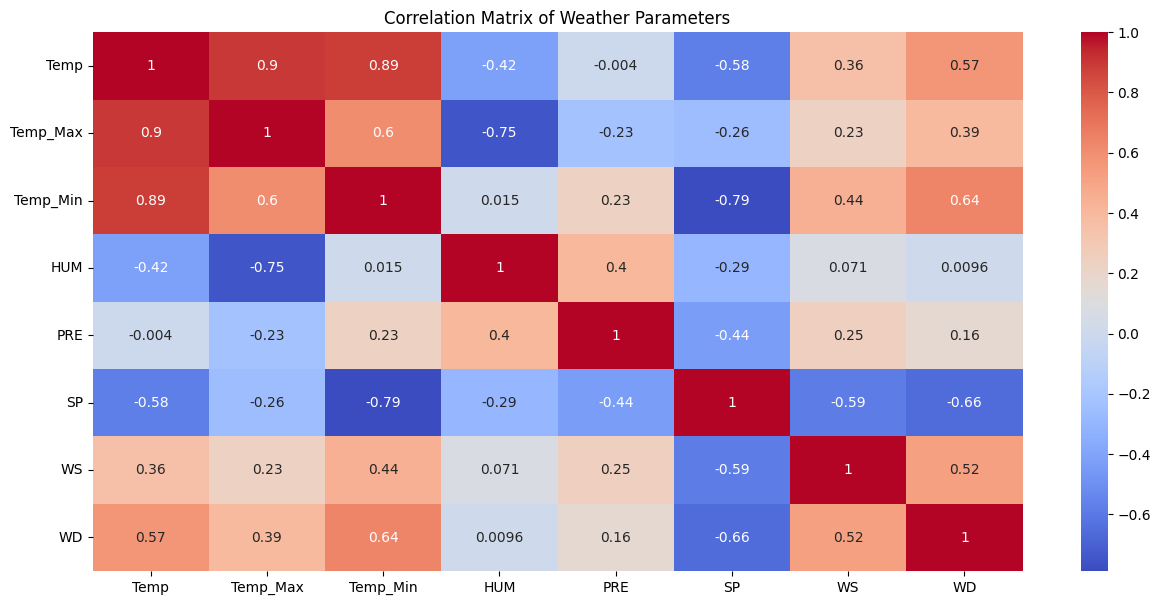

In [68]:
import seaborn as sns

plt.figure(figsize=(15, 7))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Weather Parameters')
plt.show()


<Figure size 2000x700 with 0 Axes>

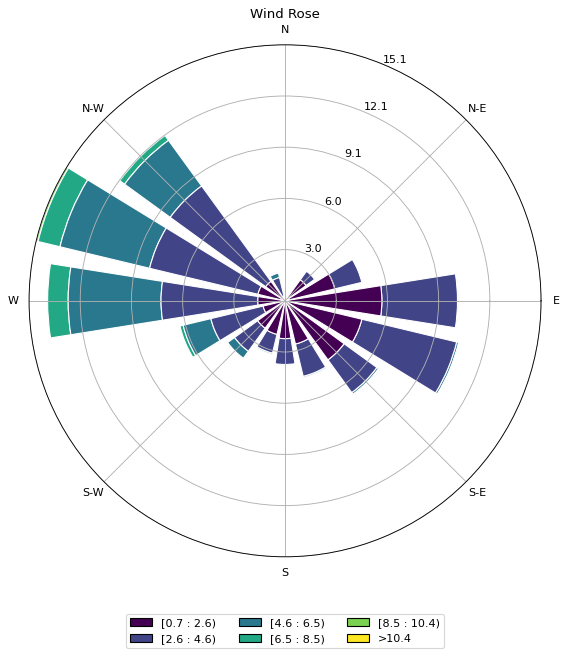

In [69]:
from windrose import WindroseAxes

# Assuming 'WD' is wind direction and 'WS' is wind speed
plt.figure(figsize=(20, 7))
ax = WindroseAxes.from_ax()
ax.bar(data['WD'], data['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose')
ax.legend(ncol=3, bbox_to_anchor=(0.5, -0.1), loc='upper center')
plt.show()

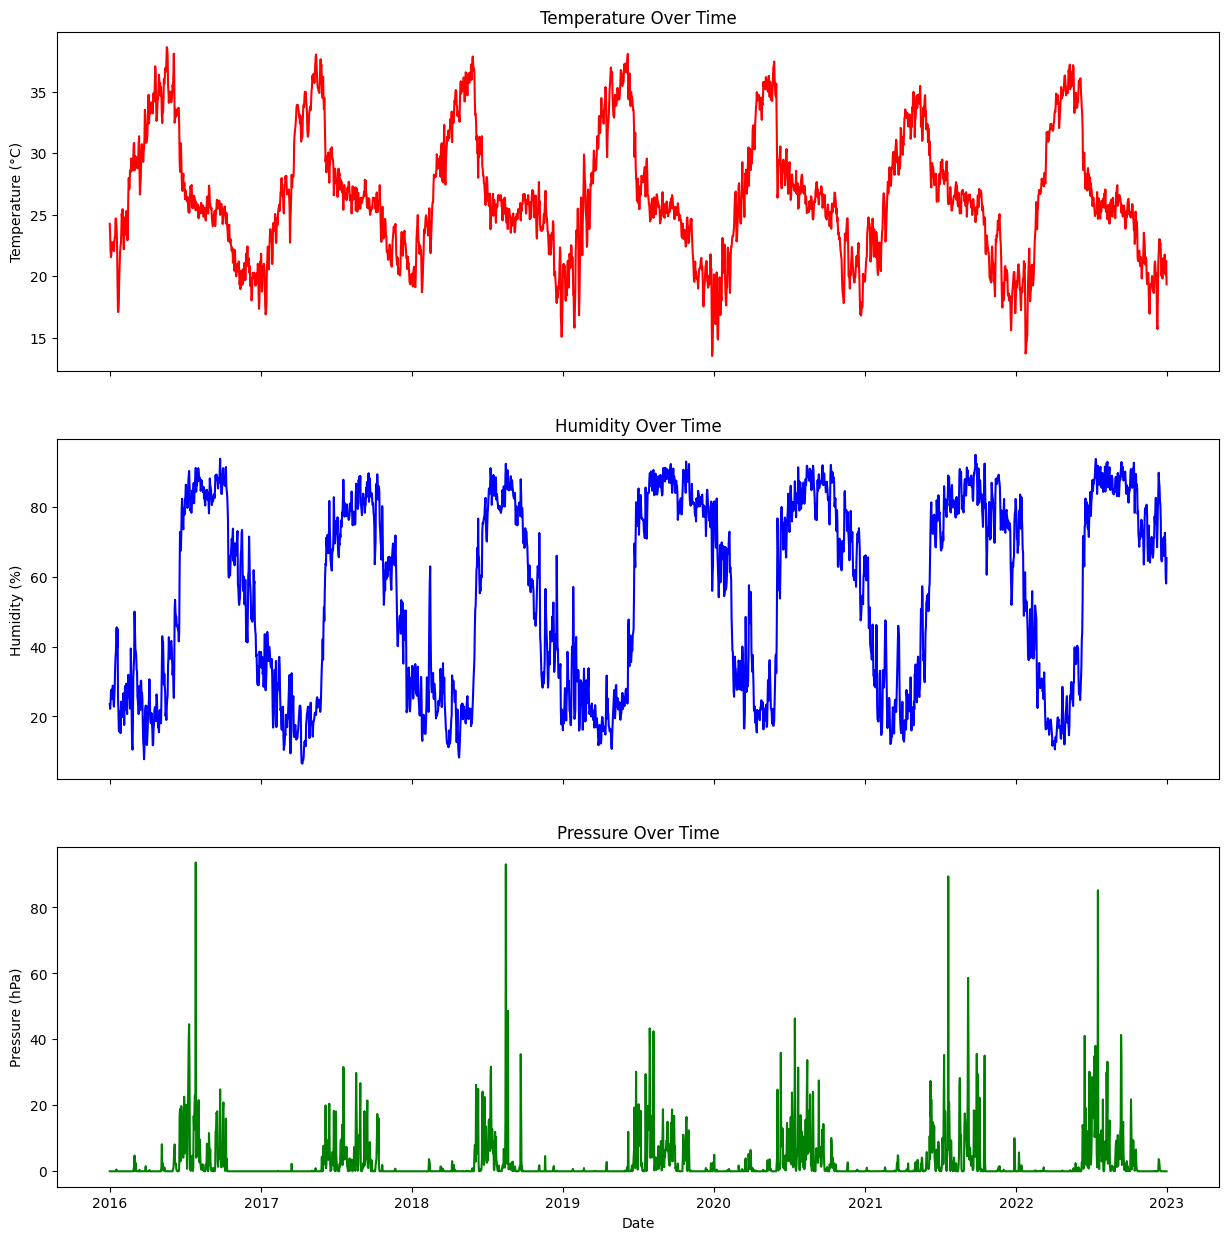

In [70]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
axs[0].plot(data['Date'], data['Temp'], label='Temperature (°C)', color='red')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_title('Temperature Over Time')

axs[1].plot(data['Date'], data['HUM'], label='Humidity (%)', color='blue')
axs[1].set_ylabel('Humidity (%)')
axs[1].set_title('Humidity Over Time')

axs[2].plot(data['Date'], data['PRE'], label='Pressure (hPa)', color='green')
axs[2].set_ylabel('Pressure (hPa)')
axs[2].set_title('Pressure Over Time')

plt.xlabel('Date')
plt.show()


In [71]:
# Split into train and test sets
train_size = int(len(time_series) * 0.8)
train, test = time_series[0:train_size], time_series[train_size:]
train_dates, test_dates = dates[0:train_size], dates[train_size:]

In [72]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))

In [73]:
# Create dataset function
def create_dataset(dataset, dates, look_back=1):
    X, Y, D = [], [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
        D.append(dates[i + look_back])
    return np.array(X), np.array(Y), np.array(D)

# Parameters
look_back = 10

In [74]:
# Create train and test datasets
X_train, y_train, train_dates_new = create_dataset(train_scaled, train_dates, look_back)
X_test, y_test, test_dates_new = create_dataset(test_scaled, test_dates, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## LSTM

In [14]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-traina

In [16]:
# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
2035/2035 [==============================] - 11s 4ms/step - loss: 0.0081
Epoch 2/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0043
Epoch 3/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0033
Epoch 4/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0030
Epoch 5/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0028
Epoch 6/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0027
Epoch 7/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0025
Epoch 8/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0023
Epoch 9/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0024
Epoch 10/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0025


In [21]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

16/16 [==============================] - 0s 2ms/step


In [29]:
# Print the predictions and actual values side by side
print("Test Predictions vs. Actual Test Data:")
print("Index\tPredicted\tActual")
for i in range(5):
#for i in range(len(test_predict)):
    print(f"{i}\t{test_predict[i][0]:.2f}\t\t{y_test[i][0]:.2f}")


Test Predictions vs. Actual Test Data:
Index	Predicted	Actual
0	25.83		25.56
1	25.04		25.09
2	24.72		25.47
3	25.14		25.21
4	24.74		25.10


In [23]:
# Calculate metrics
train_score_mse = mean_squared_error(y_train, train_predict)
test_score_mse = mean_squared_error(y_test, test_predict)
train_score_mae = mean_absolute_error(y_train, train_predict)
test_score_mae = mean_absolute_error(y_test, test_predict)
train_score_r2 = r2_score(y_train, train_predict)
test_score_r2 = r2_score(y_test, test_predict)

print(f'Train Score: MSE={train_score_mse:.2f}, MAE={train_score_mae:.2f}, R2={train_score_r2:.2f}')
print(f'Test Score: MSE={test_score_mse:.2f}, MAE={test_score_mae:.2f}, R2={test_score_r2:.2f}')

Train Score: MSE=1.09, MAE=0.84, R2=0.96
Test Score: MSE=0.89, MAE=0.75, R2=0.97


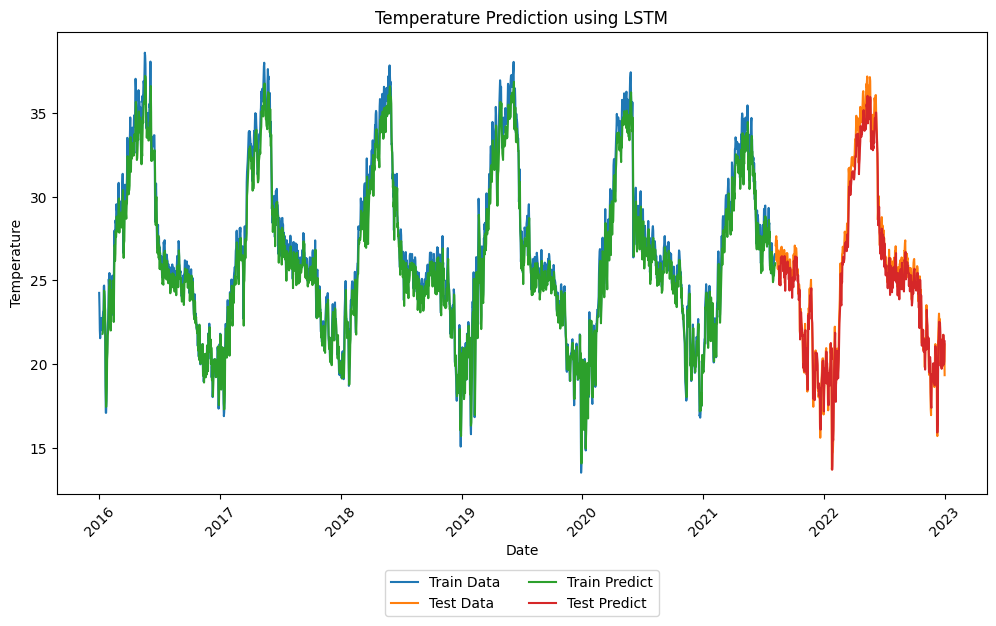

In [28]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train_dates, scaler.inverse_transform(train_scaled), label='Train Data')
plt.plot(test_dates, scaler.inverse_transform(test_scaled), label='Test Data')
plt.plot(train_dates_new, train_predict, label='Train Predict')
plt.plot(test_dates_new, test_predict, label='Test Predict')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Prediction using LSTM')
plt.legend()
plt.xticks(rotation=45)
plt.legend(ncol=2, bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

# SimpleRNN

In [39]:
# Build the LSTM model
model1 = Sequential()
model1.add(SimpleRNN(50, return_sequences=True, input_shape=(look_back, 1)))
model1.add(Dropout(0.2))
model1.add(SimpleRNN(50, return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(25))
model1.add(Dense(1))

# Compile the model
model1.compile(optimizer='adam', loss='mean_squared_error')

In [40]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 10, 50)            2600      
                                                                 
 dropout_4 (Dropout)         (None, 10, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 8,951
Trainable params: 8,951
Non-traina

In [41]:
# Train the model
model1.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
2035/2035 [==============================] - 21s 10ms/step - loss: 0.0213
Epoch 2/10
2035/2035 [==============================] - 20s 10ms/step - loss: 0.0049
Epoch 3/10
2035/2035 [==============================] - 20s 10ms/step - loss: 0.0036
Epoch 4/10
2035/2035 [==============================] - 20s 10ms/step - loss: 0.0032
Epoch 5/10
2035/2035 [==============================] - 20s 10ms/step - loss: 0.0032
Epoch 6/10
2035/2035 [==============================] - 24s 12ms/step - loss: 0.0032
Epoch 7/10
2035/2035 [==============================] - 25s 12ms/step - loss: 0.0035
Epoch 8/10
2035/2035 [==============================] - 23s 11ms/step - loss: 0.0028
Epoch 9/10
2035/2035 [==============================] - 20s 10ms/step - loss: 0.0030
Epoch 10/10
2035/2035 [==============================] - 20s 10ms/step - loss: 0.0030


In [43]:
# Make predictions
train_predict = model1.predict(X_train)
test_predict = model1.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

16/16 [==============================] - 0s 3ms/step


In [44]:
# Print the predictions and actual values side by side
print("Test Predictions vs. Actual Test Data:")
print("Index\tPredicted\tActual")
for i in range(5):
#for i in range(len(test_predict)):
    print(f"{i}\t{test_predict[i][0]:.2f}\t\t{y_test[i][0]:.2f}")


Test Predictions vs. Actual Test Data:
Index	Predicted	Actual
0	26.78		25.56
1	26.04		25.09
2	25.74		25.47
3	25.98		25.21
4	25.77		25.10


In [45]:
# Calculate metrics
train_score_mse = mean_squared_error(y_train, train_predict)
test_score_mse = mean_squared_error(y_test, test_predict)
train_score_mae = mean_absolute_error(y_train, train_predict)
test_score_mae = mean_absolute_error(y_test, test_predict)
train_score_r2 = r2_score(y_train, train_predict)
test_score_r2 = r2_score(y_test, test_predict)

print(f'Train Score: MSE={train_score_mse:.2f}, MAE={train_score_mae:.2f}, R2={train_score_r2:.2f}')
print(f'Test Score: MSE={test_score_mse:.2f}, MAE={test_score_mae:.2f}, R2={test_score_r2:.2f}')

Train Score: MSE=1.07, MAE=0.80, R2=0.96
Test Score: MSE=1.11, MAE=0.82, R2=0.96


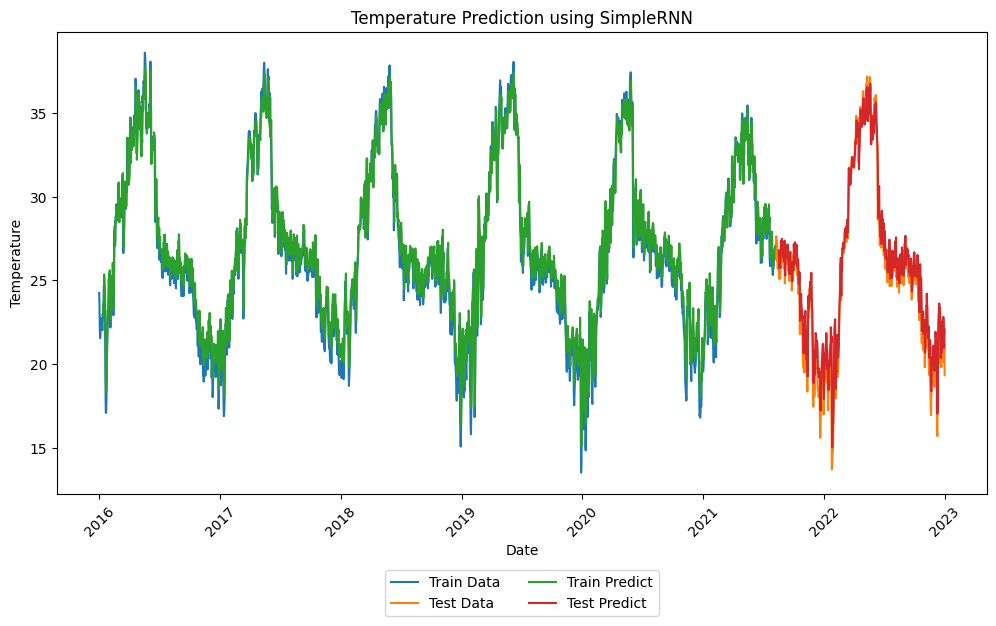

In [46]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train_dates, scaler.inverse_transform(train_scaled), label='Train Data')
plt.plot(test_dates, scaler.inverse_transform(test_scaled), label='Test Data')
plt.plot(train_dates_new, train_predict, label='Train Predict')
plt.plot(test_dates_new, test_predict, label='Test Predict')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Prediction using SimpleRNN')
plt.legend()
plt.xticks(rotation=45)
plt.legend(ncol=2, bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

# GRU

In [75]:
# Build the LSTM model
model_GRU = Sequential()
model_GRU.add(GRU(50, return_sequences=True, input_shape=(look_back, 1)))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(50, return_sequences=False))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(25))
model_GRU.add(Dense(1))

# Compile the model
model_GRU.compile(optimizer='adam', loss='mean_squared_error')

In [76]:
model_GRU.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 10, 50)            7950      
                                                                 
 dropout_12 (Dropout)        (None, 10, 50)            0         
                                                                 
 gru_8 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 25)                1275      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 24,551
Trainable params: 24,551
Non-trai

In [77]:
# Train the model
model_GRU.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
2035/2035 [==============================] - 9s 4ms/step - loss: 0.0065
Epoch 2/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0033
Epoch 3/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0028
Epoch 4/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0027
Epoch 5/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0027
Epoch 6/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0028
Epoch 7/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0025
Epoch 8/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0025
Epoch 9/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0024
Epoch 10/10
2035/2035 [==============================] - 8s 4ms/step - loss: 0.0024


In [78]:
# Make predictions
train_predict = model_GRU.predict(X_train)
test_predict = model_GRU.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

16/16 [==============================] - 0s 4ms/step


In [79]:
# Print the predictions and actual values side by side
print("Test Predictions vs. Actual Test Data:")
print("Index\tPredicted\tActual")
for i in range(5):
#for i in range(len(test_predict)):
    print(f"{i}\t{test_predict[i][0]:.2f}\t\t{y_test[i][0]:.2f}")


Test Predictions vs. Actual Test Data:
Index	Predicted	Actual
0	26.31		25.56
1	25.38		25.09
2	25.13		25.47
3	25.58		25.21
4	25.17		25.10


In [80]:
# Calculate metrics
train_score_mse = mean_squared_error(y_train, train_predict)
test_score_mse = mean_squared_error(y_test, test_predict)
train_score_mae = mean_absolute_error(y_train, train_predict)
test_score_mae = mean_absolute_error(y_test, test_predict)
train_score_r2 = r2_score(y_train, train_predict)
test_score_r2 = r2_score(y_test, test_predict)

print(f'Train Score: MSE={train_score_mse:.2f}, MAE={train_score_mae:.2f}, R2={train_score_r2:.2f}')
print(f'Test Score: MSE={test_score_mse:.2f}, MAE={test_score_mae:.2f}, R2={test_score_r2:.2f}')

Train Score: MSE=0.81, MAE=0.69, R2=0.97
Test Score: MSE=0.72, MAE=0.64, R2=0.97


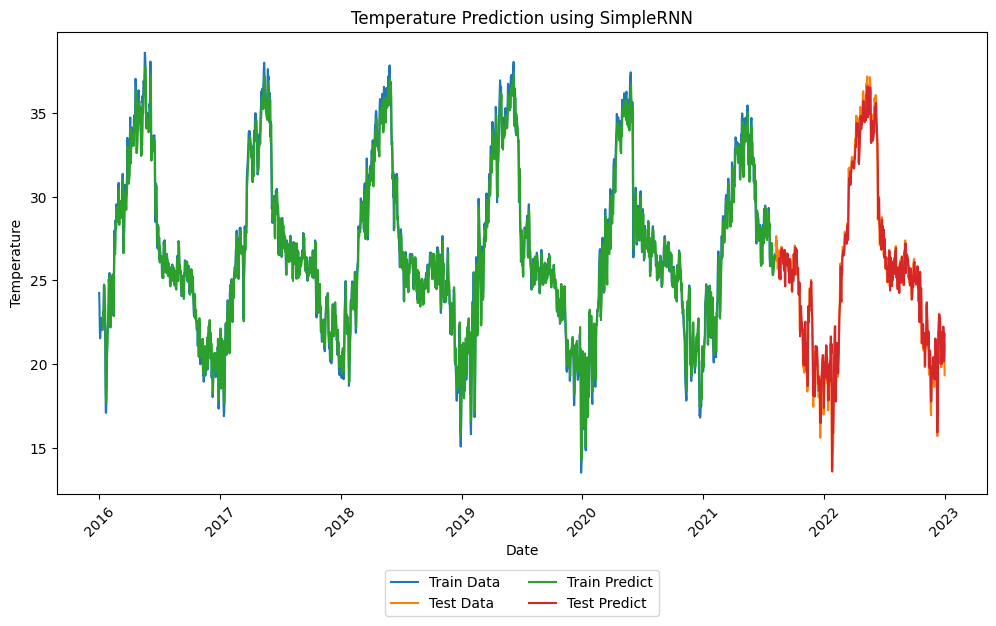

In [81]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train_dates, scaler.inverse_transform(train_scaled), label='Train Data')
plt.plot(test_dates, scaler.inverse_transform(test_scaled), label='Test Data')
plt.plot(train_dates_new, train_predict, label='Train Predict')
plt.plot(test_dates_new, test_predict, label='Test Predict')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Prediction using SimpleRNN')
plt.legend()
plt.xticks(rotation=45)
plt.legend(ncol=2, bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()